In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc

In [ ]:
train = pd.read_csv("Train.csv")
valid = pd.read_csv("Valid.csv")
test  = pd.read_csv("Test.csv")

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [ ]:
train.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [ ]:
def Preprocessing(text):
    text = re.sub(r'[^\w\s]','',text)
    text = text.lower()
    text = [w for w in text.split(' ') if w not in stopwords.words('english')]
    text = [WordNetLemmatizer().lemmatize(token) for token in text]
    text = [WordNetLemmatizer().lemmatize(token,pos='v') for token in text]
    text = " ".join(text)
    return text

train['text'] = train.text.apply(lambda x:Preprocessing(x))
valid['text'] = valid.text.apply(lambda x:Preprocessing(x))
test['text']= test.text.apply(lambda x:Preprocessing(x))

In [ ]:
train['label'].value_counts()

0    20019
1    19981
Name: label, dtype: int64

In [ ]:
X_train = train['text']
X_valid = valid['text']
X_test = test['text']
y_train = train['label']
y_valid = valid['label']
y_test = test['label']

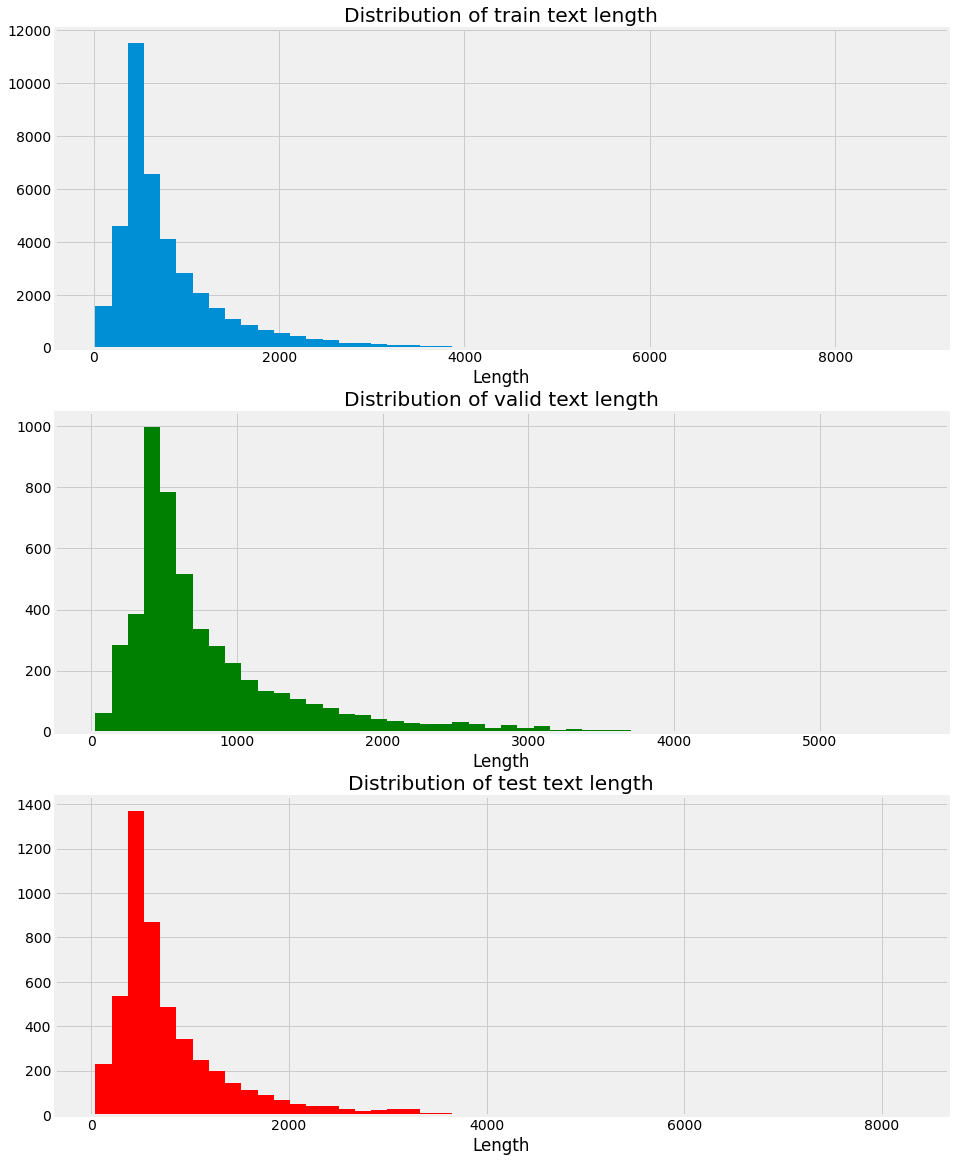

In [ ]:
plt.figure(figsize=(16,20))
plt.style.use('fivethirtyeight')

plt.subplot(3,1,1)
train_len = [len(l) for l in X_train]
plt.hist(train_len,bins=50)
plt.title('Distribution of train text length')
plt.xlabel('Length')

plt.subplot(3,1,2)
valid_len = [len(l) for l in X_valid]
plt.hist(valid_len,bins=50,color='green')
plt.title('Distribution of valid text length')
plt.xlabel('Length')

plt.subplot(3,1,3)
test_len = [len(l) for l in X_test]
plt.hist(test_len,bins=50,color='red')
plt.title('Distribution of test text length')
plt.xlabel('Length')

plt.show()

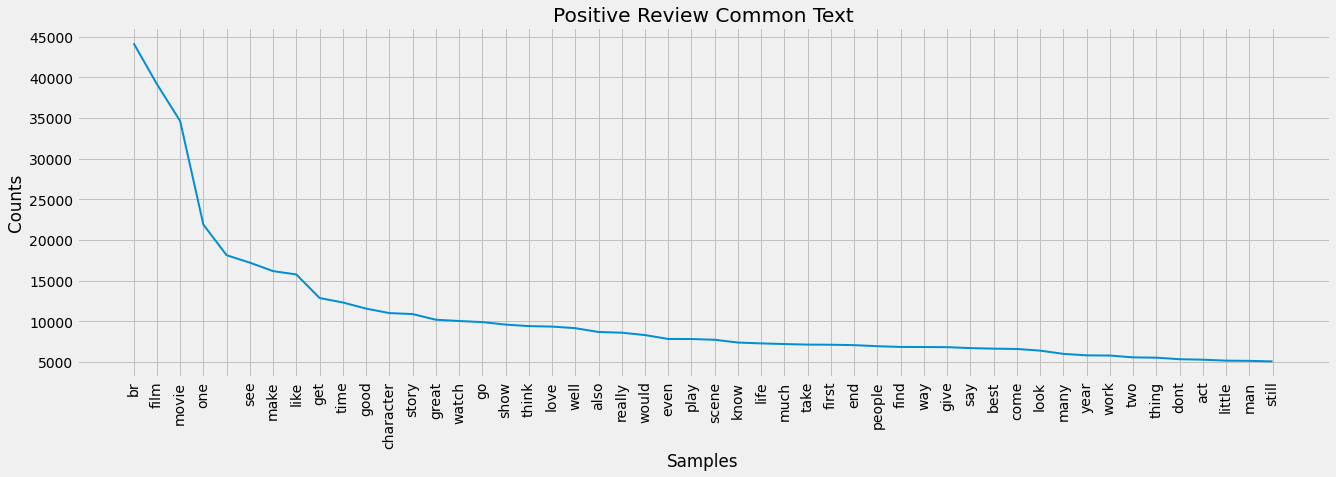

In [ ]:
pos_freq = FreqDist(' '.join(train[train['label'] == 1].text).split(' '))
plt.figure(figsize=(20,6))
pos_freq.plot(50,cumulative=False,title='Positive Review Common Text')
plt.show()

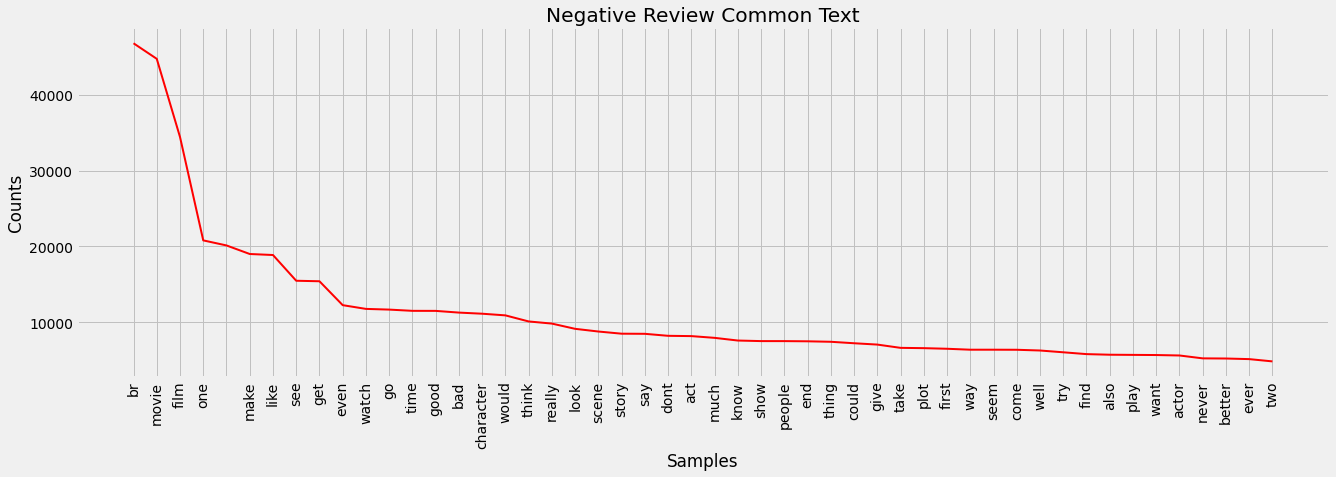

In [ ]:
neg_freq = FreqDist(' '.join(train[train['label'] == 0].text).split(' '))
plt.figure(figsize=(20,6))
neg_freq.plot(50,cumulative=False,title='Negative Review Common Text',color='red')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the sentences
tokenizer = Tokenizer()

# preparing vocabulary
tokenizer.fit_on_texts(X_train)

# converting text into integer sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_valid = tokenizer.texts_to_sequences(X_valid)
X_test  = tokenizer.texts_to_sequences(X_test)

# padding to prepare sequences of same length
X_train = pad_sequences(X_train, maxlen=120)
X_valid = pad_sequences(X_valid, maxlen=120)
X_test  = pad_sequences(X_test,  maxlen=120)

In [ ]:
size_of_vocabulary = len(tokenizer.word_index)+1
print(size_of_vocabulary)

140631


In [ ]:
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
# embedding layer
model.add(Embedding(size_of_vocabulary,128,input_length=120))
# lstm layer
model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True,dropout=0.2)))
model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True,dropout=0.2)))
model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True,dropout=0.2)))
model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True,dropout=0.2)))
model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True,dropout=0.2)))

model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True,dropout=0.2)))
model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True,dropout=0.2)))
model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True,dropout=0.2)))
model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True,dropout=0.2)))
model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True,dropout=0.2)))

model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True,dropout=0.2)))
model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True,dropout=0.2)))
model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True,dropout=0.2)))
model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True,dropout=0.2)))
model.add(Bidirectional(LSTM(64, return_sequences=True,dropout=0.2)))
# Global Maxpooling
model.add(GlobalMaxPooling1D())
# Dense Layer
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(1,activation='sigmoid'))
# Add loss function, metrics, optimizer
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# Adding callbacks
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True,verbose=1)
# summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 128)          18000768  
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 120, 128)          98816     
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 120, 128)          98816     
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 120, 128)          98816     
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 120, 128)          98816     
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 120, 128)          98816     
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 120, 128)         

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=20,
                    validation_data=(X_valid, y_valid), verbose=1, callbacks=[es,mc])

Epoch 1/20
313/313 [==============================] - 140s 334ms/step - loss: 0.4319 - accuracy: 0.8003 - val_loss: 0.3356 - val_accuracy: 0.8656

Epoch 00001: val_accuracy improved from -inf to 0.86560, saving model to best_model.h5
Epoch 2/20
313/313 [==============================] - 98s 312ms/step - loss: 0.2616 - accuracy: 0.9023 - val_loss: 0.3605 - val_accuracy: 0.8670

Epoch 00002: val_accuracy improved from 0.86560 to 0.86700, saving model to best_model.h5
Epoch 3/20
313/313 [==============================] - 98s 312ms/step - loss: 0.1771 - accuracy: 0.9386 - val_loss: 0.3135 - val_accuracy: 0.8764

Epoch 00003: val_accuracy improved from 0.86700 to 0.87640, saving model to best_model.h5
Epoch 4/20
313/313 [==============================] - 98s 313ms/step - loss: 0.1156 - accuracy: 0.9628 - val_loss: 0.3422 - val_accuracy: 0.8780

Epoch 00004: val_accuracy improved from 0.87640 to 0.87800, saving model to best_model.h5
Epoch 5/20
313/313 [==============================] - 97s 